In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from aodfunctions.dependencies import *
from aodfunctions.general import *
from aodfunctions.settings import *

cupyon=True

try:
    import cupy as cp
    import numpy as np
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")


Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [2]:
## Global Variables - REMEMBER TO UPDATE SETTINGS WHEN CHANGED
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 500
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 30*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = 50*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 100*10**(-6) # End location of the AOD in microns


optimizationbasisfunctions = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

num_particles = 1000
atommass = 1.41922*10**(-25) # Mass of the atom
tweezerdepth = 10*10**6 # Depth of the tweezer in Hertz
hbar = 6.626*10**(-34)


globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables



Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [3]:
### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)

print("Tweezer starting positions:", startlocation*10**6, "microns or", micronstoMHz(startlocation, globalvariables) /10**6, "MHz")
print("Tweezer ending positions:", endlocation*10**6, "microns or", micronstoMHz(endlocation, globalvariables) /10**6, "MHz")
print("One micron corresponds to", micronstoMHz(1e-6, globalvariables) /10**6, "MHz")

Tweezer starting positions: 49.99999999999999 microns or 5.668934240362814 MHz
Tweezer ending positions: 99.99999999999999 microns or 11.337868480725623 MHz
One micron corresponds to 0.1133786848072586 MHz


In [4]:
# optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_linearramp(globalvariables)
# optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_minimizejerk(globalvariables)


optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)
expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)

AWGinitguesscosine = initguess_continuouscosine(AWGwaveform, optimized_position, time, globalvariables)
potentials = retrievepotentials(AWGinitguesscosine, globalvariables, 1, True)
forces = retrieveforces(AWGinitguesscosine, globalvariables, 1, True)
initial_x_dx= initdistribution_MaxwellBoltzmann(num_particles, 40e-6, 1e-8, atommass, globalvariables)



# Mid-code visualizations
# plot_arrays([(tonumpy(zoomin(potentials[0] /hbar/10**6, 2))), zoomin(forces[0] /hbar/10**6 /10**6,50000).get(),zoomin(forces[0] /atommass,50000).get()], ["Potential (MHz)", "Force (MHz / micron)", "Acceleration (m/s^2)"])

# plt.figure(figsize=(12, 6))
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[0:500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[-500:],globalvariables)).get())
# plt.plot(potentials[-1].get())
# plt.plot(potentials[0].get())


# plt.axvline(x=positionstofourier(startlocation, 0, globalvariables)[0], color='red', linestyle='--')
# plt.axvline(x=positionstofourier(endlocation, 0, globalvariables)[0], color='blue', linestyle='--')
# print(positionstofourier(startlocation, 0, globalvariables)[0])
# print(positionstofourier(endlocation, 0, globalvariables)[0])


# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ax1.hist(initial_x_dx[0], color='blue')
# ax1.set_title('Position')
# ax1.set_xlabel('Fourier Pixels')
# ax1.set_ylabel('Count')

# ax2.hist(initial_x_dx[1], color='red')
# ax2.set_title('Velocity')
# ax2.set_xlabel('m/s')
# ax2.set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [5]:
forces = retrieveforces_idealconditions(AWGinitguesscosine, optimized_position,globalvariables)

In [6]:
forces_notideal = retrieveforces(AWGinitguesscosine, globalvariables, 1, False)


In [7]:
potentials = retrievepotentials(AWGinitguesscosine, globalvariables, 1, False)

In [8]:
potentials_ideal = retrievepotentials_idealconditions(AWGinitguesscosine, optimized_position, globalvariables)

In [9]:
rescalingfac = np.max(np.gradient(potentials_ideal[0])) / np.max(gradient(potentials[0]).get())

In [10]:
rescalingfac2 = np.max((potentials_ideal[0])) / np.max((potentials[0]).get())

In [11]:
rescalingfac2*potentials[0]

array([1.23202634e-24, 1.05992603e-24, 6.39967019e-25, ...,
       2.07243514e-25, 6.39967019e-25, 1.05992603e-24])

In [12]:
potentials[0]

array([1.16086386e-31, 9.98704150e-32, 6.03002192e-32, ...,
       1.95273021e-32, 6.03002192e-32, 9.98704150e-32])

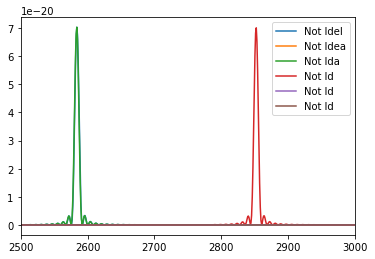

In [13]:
plt.plot(tonumpy(potentials[0]*rescalingfac2), label='Not Idel')
plt.plot(tonumpy(potentials[1800]*rescalingfac2), label='Not Idea')
plt.plot((potentials_ideal[0]), label='Not Ida')
plt.plot((potentials_ideal[900]), label='Not Id')
plt.plot((potentials_ideal[1600]), label='Not Id')
plt.plot((potentials_ideal[1700]), label='Not Id')

plt.xlim(2500,3000)
plt.legend()

(2500.0, 3000.0)

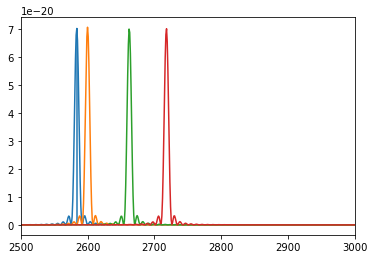

In [14]:
plt.plot(tonumpy(potentials_ideal[0]), label='Not Idel')
plt.plot(tonumpy(potentials_ideal[200]), label='Not Idel')

plt.plot(tonumpy(potentials_ideal[450]), label='Not Idel')

plt.plot(tonumpy(potentials_ideal[600]), label='Not Idel')

plt.vlines(x =find_max_peak_location(removeleftside(tonumpy(potentials_ideal[0]))), ymin = 0, ymax = np.max(tonumpy(potentials[0]*rescalingfac2)))
plt.xlim(2500,3000)


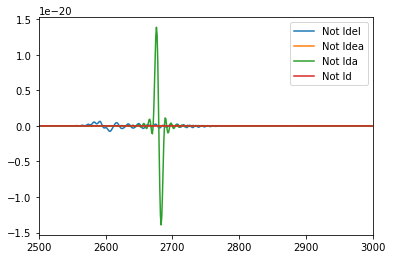

In [15]:
plt.plot(gradient(potentials[500]).get()*rescalingfac, label='Not Idel')
plt.plot(gradient(potentials[1800]).get()*rescalingfac, label='Not Idea')
plt.plot(np.gradient(potentials_ideal[500]), label='Not Ida')
plt.plot(np.gradient(potentials_ideal[1800]), label='Not Id')

plt.xlim(2500,3000)
plt.legend()

No handles with labels found to put in legend.


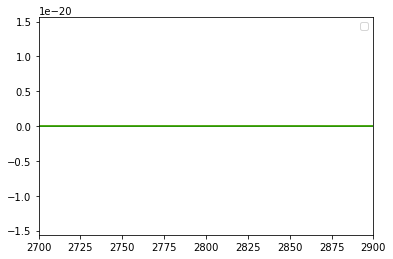

In [16]:

plt.plot(forces[-1].get(), color='yellow')
plt.plot(forces_notideal[-1].get(), color='green')

plt.xlim(2700,2900)
plt.legend()

In [17]:
# plot_arrays([(tonumpy(zoomin(potentials[0] /hbar/10**6, 2))), zoomin(forces[0] /hbar/10**6 /10**6,50000).get(),zoomin(forces[0] /atommass,50000).get()], ["Potential (MHz)", "Force (MHz / micron)", "Acceleration (m/s^2)"])

# plt.figure(figsize=(12, 6))
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[0:500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[3000:3500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[-500:],globalvariables)).get())
# plt.plot(potentials[-1].get())
# plt.plot(potentials[0].get())
# plt.xlim(2400,2900)

# plt.axvline(x=positionstofourier(startlocation, 0, globalvariables)[0], color='red', linestyle='--')
# plt.axvline(x=positionstofourier(endlocation, 0, globalvariables)[0], color='blue', linestyle='--')
# print(positionstofourier(startlocation, 0, globalvariables)[0])
# print(positionstofourier(endlocation, 0, globalvariables)[0])


# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ax1.hist(initial_x_dx[0], color='blue')
# ax1.set_title('Position')
# ax1.set_xlabel('Fourier Pixels')
# ax1.set_ylabel('Count')

# ax2.hist(initial_x_dx[1], color='red')
# ax2.set_title('Velocity')
# ax2.set_xlabel('m/s')
# ax2.set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [18]:
from aodfunctions.general import *

In [19]:
movetimes = np.array([35,45,55,60,80,90,100,110,120,130,140,150,160,170])*10**(-6)
movetemperatures = np.array([1,10,30])*10**(-6)

# movetimes = np.array([200])*10**(-6)
# movetemperatures = np.array([1])*10**(-6)


ideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Ideal", "Linear", 1, globalvariables)
notideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Not Ideal", "Linear", 1, globalvariables)
idealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Ideal", "SinSq", 1, globalvariables)
notidealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Not Ideal", "SinSq", 1, globalvariables)


1.3922284389551198e-20
3120.120021077406
1.3922284389551198e-20
3120.120021077406
1.3922284389551198e-20
3120.120021077406
1.3906481444991295e-20
3120.048176421579
1.3906481444991295e-20
3120.048176421579
1.3906481444991295e-20
3120.048176421579
1.3876004990520663e-20
3120.010244584339
1.3876004990520663e-20
3120.010244584339
1.3876004990520663e-20
3120.010244584339
1.3894028270374574e-20
3119.9918698946376
1.3894028270374574e-20
3119.9918698946376
1.3894028270374574e-20
3119.9918698946376
1.3886554043449104e-20
3119.9334324625474
1.3886554043449104e-20
3119.9334324625474
1.3886554043449104e-20
3119.9334324625474
1.3884629315359815e-20
3119.89892656498
1.3884629315359815e-20
3119.89892656498
1.3884629315359815e-20
3119.89892656498
1.3879199794956028e-20
3119.893842648825
1.3879199794956028e-20
3119.893842648825
1.3879199794956028e-20
3119.893842648825
1.3882535307664842e-20
3119.866465747863
1.3882535307664842e-20
3119.866465747863
1.3882535307664842e-20
3119.866465747863
1.38820026355

In [27]:
def plots_fixeddistance(movementtimes, initialtemperatures, analysisout):
    """
    Plot the results of the fixed distance analysis.
    
    Parameters:
    analysisout (np.ndarray): Array of results from the fixed distance analysis.
    """
    # Get the number of movement times and initial temperatures
    num_movementtimes, num_initialtemperatures = analysisout.shape
    kb = 1.38*10**(-23)

    # Create a figure and axis
    fig, axs = plt.subplots(1,2,figsize=(15, 6))

    # Iterate over each combination of movement time and initial temperature
    for j in range(num_initialtemperatures):
        # Initialize an empty list to store the survival rates for each movement time
        survival_rates = []
        temperatures = []
        # Iterate over each movement time
        for i in range(num_movementtimes):
            # Get the results for the current combination
            survivalrate, xout, vout = analysisout[i, j]
            vout = tonumpy(vout)
            temperature = np.mean(vout**2 * atommass / (3*kb))
            # Append the survival rate to the list
            survival_rates.append(survivalrate)
            temperatures.append(temperature* 1e6)
        # Plot the survival rates for the current initial temperature
        axs[0].plot(movementtimes * 1e6, survival_rates, label=f"T0: {initialtemperatures[j] * 1e6:.2f} μK")
        
        # Plot the temperatures for the current initial temperature
        axs[1].plot(movementtimes * 1e6, temperatures, label=f"T0: {initialtemperatures[j] * 1e6:.2f} μK")

    # Set labels, title, and legend for survival rate plot
    axs[0].set_xlabel('Movement Time (μs)')
    axs[0].set_ylabel('Survival Probability')
    axs[0].set_title('Survival Probability vs Movement Time')
    axs[0].set_ylim(0, 100)
    axs[0].legend()

    # Set labels, title, and legend for temperature plot
    axs[1].set_xlabel('Movement Time (μs)')
    axs[1].set_ylabel('Temperature (μK)')
    axs[1].set_title('Temperature vs Movement Time')
    axs[1].legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

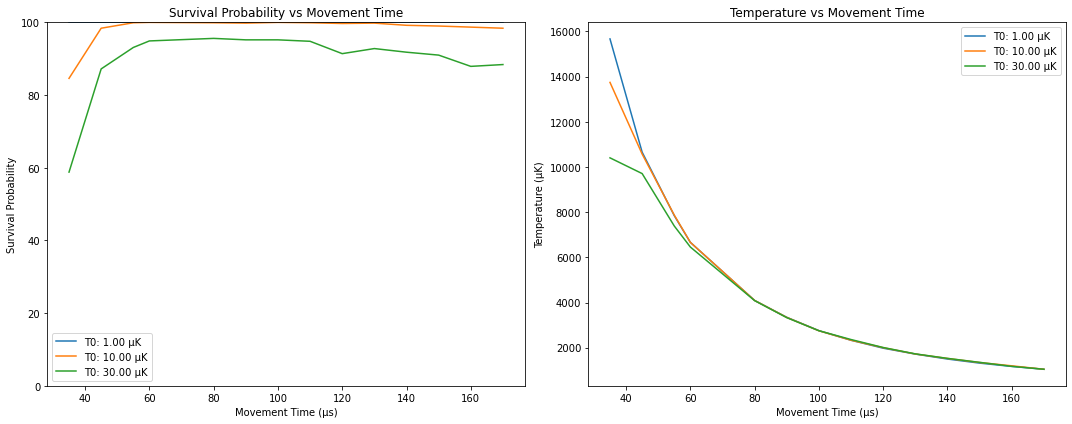

In [28]:
plots_fixeddistance(movetimes, movetemperatures, ideallinear)

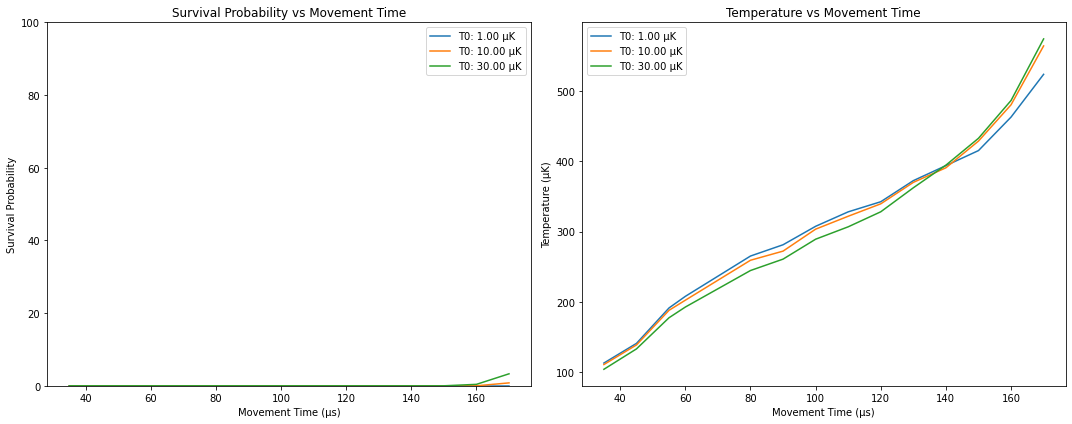

In [29]:
plots_fixeddistance(movetimes, movetemperatures, notideallinear)

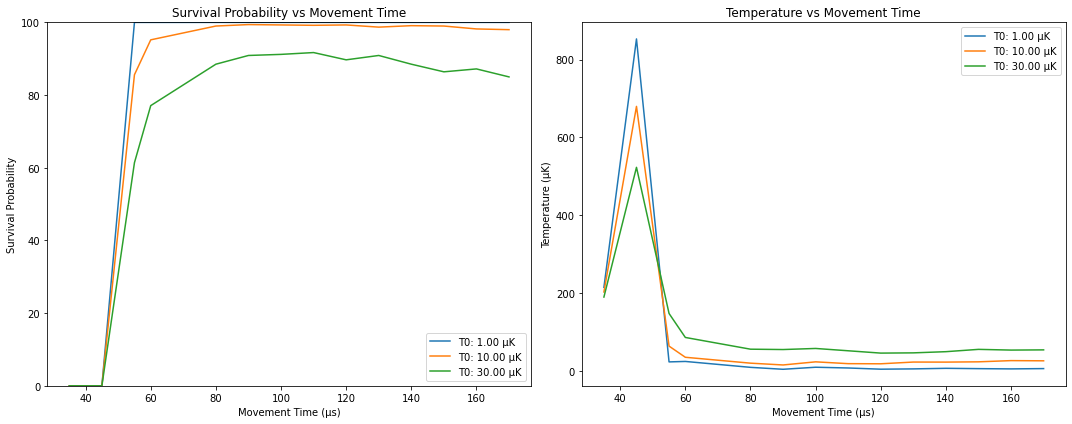

In [30]:
plots_fixeddistance(movetimes, movetemperatures, idealsinsq)

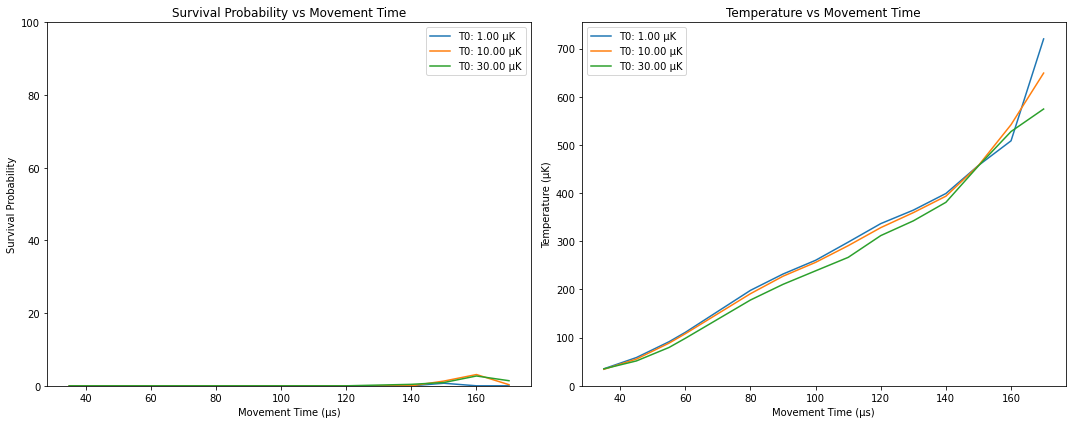

In [31]:
plots_fixeddistance(movetimes, movetemperatures, notidealsinsq)

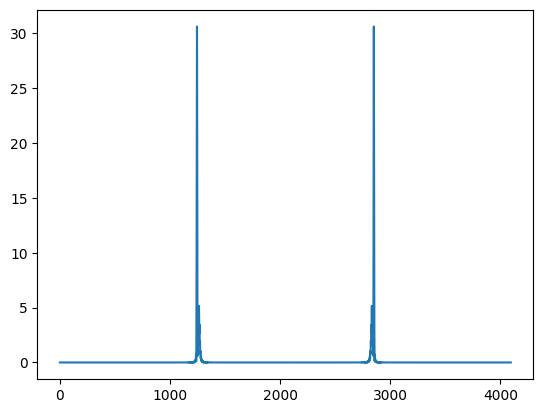

In [14]:
plt.plot(potentials[-400].get())




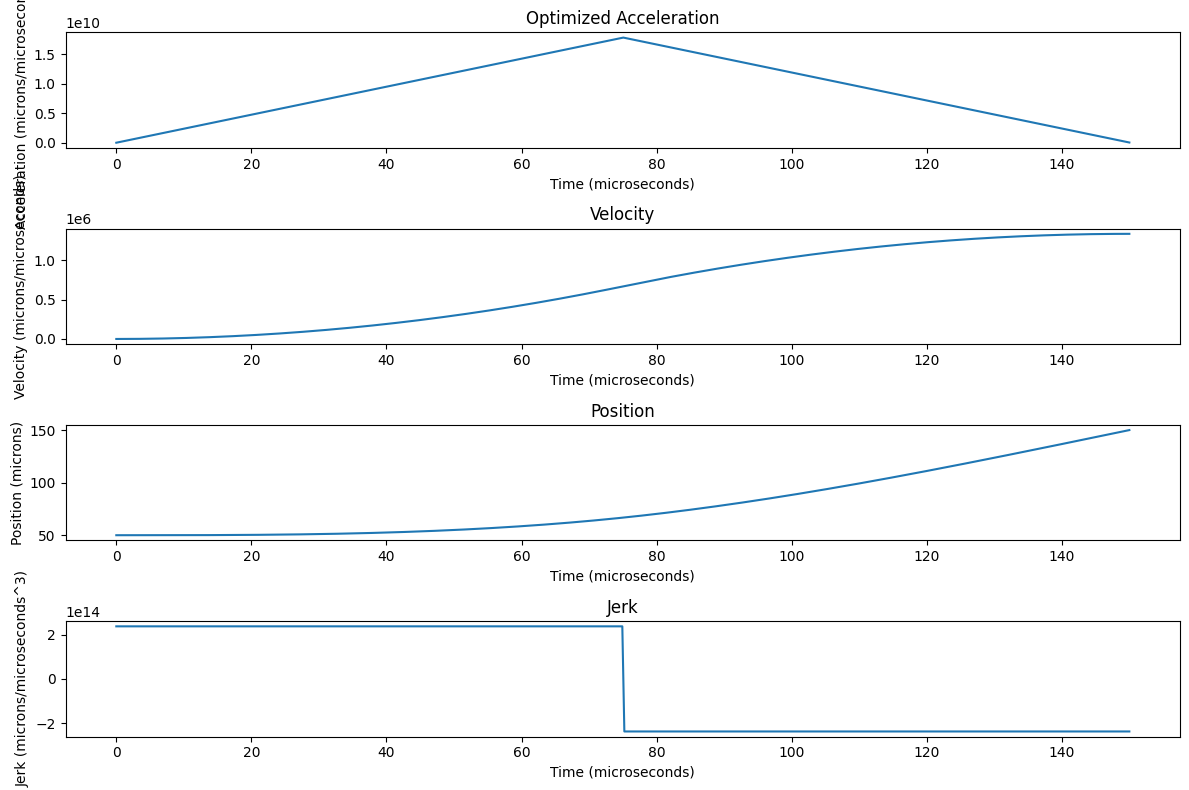

In [15]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time * 10**6, optimized_acceleration * 10**6)
plt.title('Optimized Acceleration')
plt.xlabel('Time (microseconds)')
plt.ylabel('Acceleration (microns/microseconds^2)')

plt.subplot(4, 1, 2)
plt.plot(time* 10**6, optimized_velocity* 10**6)
plt.title('Velocity')
plt.xlabel('Time (microseconds)')
plt.ylabel('Velocity (microns/microseconds)')

plt.subplot(4, 1, 3)
plt.plot(time* 10**6, optimized_position* 10**6)
plt.title('Position')
plt.xlabel('Time (microseconds)')
plt.ylabel('Position (microns)')

plt.subplot(4, 1, 4)
plt.plot(time* 10**6, optimized_jerk* 10**6)
plt.title('Jerk')
plt.xlabel('Time (microseconds)')
plt.ylabel('Jerk (microns/microseconds^3)')

plt.tight_layout()
plt.show()